In [1]:
pip install dalib

     |████████████████████████████████| 276kB 21.9MB/s 
  Created wheel for qpsolvers: filename=qpsolvers-1.5-cp36-none-any.whl size=18786 sha256=b6f7f3225c7916f7857e2cc06eb626389f59230441077ea2722f5e4c1c930ab4
  Stored in directory: /root/.cache/pip/wheels/fb/a5/1e/3e89d47de3119b73353251e3aea23e1dd678960b50de06a86f
  Created wheel for quadprog: filename=quadprog-0.1.8-cp36-cp36m-linux_x86_64.whl size=336083 sha256=4d38820afd46d15ebea2b4b14ef35da67fefe23a77883b1234fabb96431220af
  Stored in directory: /root/.cache/pip/wheels/0c/39/5f/c712b0e462439dec9b30080cf34622f167929b39bd964d8baf
Successfully built qpsolvers quadprog


In [2]:
import random
import time
import warnings
import sys
import argparse
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as col
from sklearn.manifold import TSNE

import torch
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from torch.optim import SGD
import torch.utils.data
from torch.utils.data import DataLoader
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torch.nn.functional as F

sys.path.append('.')
from dalib.modules.domain_discriminator import DomainDiscriminator
from dalib.adaptation.dann import DomainAdversarialLoss, ImageClassifier
import dalib.vision.datasets as datasets
import dalib.vision.models as models
#from tools.utils import AverageMeter, ProgressMeter, accuracy, ForeverDataIterator
#from tools.transforms import ResizeImage
#from tools.lr_scheduler import StepwiseLR

# add library
from torchvision.models import alexnet
import torch.nn as nn
from torch.autograd import Variable

# GPUが使用できるかを確認
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# RNG
seed = 0
random.seed(seed)
torch.manual_seed(seed)

# Cudnn setting
cudnn.deterministic = False
cudnn.benchmark = True

def Office31_loader(task, batch_size,train:bool,data_dir = "data/office31"):

    # Computed with compute_mean_std.py
    mean_std = {
        'A': {
            'mean': [0.79235494, 0.7862071 , 0.78418255],
            'std':  [0.31496558, 0.3174693 , 0.3193569 ]
        },
        'D': {
            'mean': [0.47086468, 0.44865608, 0.40637794],
            'std':  [0.20395322, 0.19204104, 0.1996422 ]
        },
        'W': {
            'mean': [0.6119875 , 0.6187739 , 0.61730677],
            'std':  [0.25063968, 0.25554898, 0.25773206]
        }
    }

    if train == True:
      data_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_std[task]['mean'],
                                 std=mean_std[task]['std'])
        ])
    else:
      data_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean_std[task]['mean'],
                                 std=mean_std[task]['std'])                                                        
        ])


    dataset = datasets.office31.Office31(root=data_dir, task=task, download=True, transform=data_transform)
    dataset_loader = DataLoader(dataset, batch_size=batch_size, shuffle=train, drop_last=train)
    return dataset,dataset_loader

def coral(source, target):

    d = source.size(1)  # dim vector (number of class)

    source_c = compute_covariance(source)
    target_c = compute_covariance(target)

    loss = torch.sum(torch.mul((source_c - target_c), (source_c - target_c)))

    loss = loss / (4 * d * d)
    return loss


def compute_covariance(input_data):
    """
    Compute Covariance matrix of the input data
    """
    n = input_data.size(0)  # batch_size

    # Check if using gpu or cpu
    if input_data.is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    id_row = torch.ones(n).resize(1, n).to(device=device)
    sum_column = torch.mm(id_row, input_data)
    mean_column = torch.div(sum_column, n)
    term_mul_2 = torch.mm(mean_column.t(), mean_column)
    d_t_d = torch.mm(input_data.t(), input_data)
    c = torch.add(d_t_d, (-1 * term_mul_2)) * 1 / (n - 1)

    return c

def train(model, train_loader_dict, optimizer, lambda_coral):
  model.train()
  sum_cl = 0.0
  sum_co = 0.0
  sum_to = 0.0

  train_steps = min(len(train_loader_dict['Source']), len(train_loader_dict['Target']))

  for iteration in range(train_steps):
    source_img, source_label = next(iter(train_loader_dict['Source']))
    target_img, _ = next(iter(train_loader_dict['Target']))

    source_img, source_label = source_img.to(device), source_label.to(device)
    target_img = target_img.to(device)

    source_img, source_label = Variable(source_img), Variable(source_label)
    target_img = Variable(target_img)

    optimizer.zero_grad()

    source_out = model(source_img)
    target_out = model(target_img)

    Class_loss = F.cross_entropy(source_out, source_label)
    Coral_loss = coral(source_out, target_out)
    Total_loss = Class_loss + Coral_loss * lambda_coral

    Total_loss.backward()
    optimizer.step()

    sum_cl += Class_loss
    sum_co += Coral_loss
    sum_to += Total_loss
  
  epoch_cl, epoch_co, epoch_to = sum_cl / train_steps, sum_co / train_steps, sum_to / train_steps
  print('class : {:.4f}, coral : {:.4f}, total : {:.4f}'.format(epoch_cl, epoch_co, epoch_to))

  return epoch_cl, epoch_co


def test(model, val_loader_dict,phase):
  model.eval()
  test_loss = 0.0
  correct = 0
  with torch.no_grad():
    for img, label in val_loader_dict[phase]:
      img, label = img.to(device), label.to(device)
      out = model(img)

      # sum up batch loss
      test_loss += F.cross_entropy(out, label, size_average=False).item()
      # get the index of the max log-probability
      _,preds = torch.max(out, 1)
      correct += torch.sum(preds == label.data)
      
    test_loss /= len(val_loader_dict[phase].dataset)
    test_acc = correct / len(val_loader_dict[phase].dataset)

    print('{} loss : {:.4f} acc : {:.4f}'.format(phase, test_loss, test_acc))
  return test_loss, test_acc


def main(num_epochs):
  
  source = 'A'
  target = 'W'

  lr = 1e-3
  decay = 5e-4
  momentum = 0.9

  lambda_coral = 0.75

  batch_size = 128

  # dataset & dataloader
  source_train_dataset, source_train_loader = Office31_loader(task = source, batch_size = batch_size, train = True)
  target_train_dataset, target_train_loader = Office31_loader(task = target, batch_size = batch_size, train = True)

  source_val_dataset, source_val_loader = Office31_loader(task = source, batch_size = batch_size, train = False)
  target_val_dataset, target_val_loader = Office31_loader(task = target, batch_size = batch_size, train = False)

  train_loader_dict ={'Source':source_train_loader, 'Target':target_train_loader}
  val_loader_dict = {'Source':source_val_loader, 'Target':target_val_loader}

  n_classes = len(source_train_loader.dataset.classes)

  # AlexNet
  model = alexnet(pretrained=True)
  model.classifier[6] = nn.Linear(4096, n_classes)
  torch.nn.init.normal_(model.classifier[6].weight, mean=0, std=5e-3)
  model.classifier[6].bias.data.fill_(0.01)

  model = model.to(device)

  # optimizer 
  optimizer = torch.optim.SGD([
        {'params':  model.features.parameters()},
        {'params': model.classifier[:6].parameters()},
        # fc8 -> 7th element (index 6) in the Sequential block
        {'params': model.classifier[6].parameters(), 'lr': 10 * lr}
    ], lr=lr, momentum=momentum)
  
  # log dict
  history = {}
  history['train_class_loss'] = []
  history['train_coral_loss'] = []
  history['test_source_loss'] = []
  history['test_source_acc'] = []
  history['test_target_loss'] = []
  history['test_target_acc'] = []


  for epoch in range(1, num_epochs+1):
    print('-----------------------')
    print('Epoch {}/{}'.format(epoch,num_epochs))

    epoch_cl, epoch_co = train(model, train_loader_dict, optimizer, lambda_coral)
    s_test_loss, s_test_acc = test(model, val_loader_dict,'Source')
    t_test_loss, t_test_acc = test(model, val_loader_dict,'Target')

    history['train_class_loss'].append(epoch_cl)
    history['train_coral_loss'].append(epoch_co)
    history['test_source_loss'].append(s_test_loss)
    history['test_source_acc'].append(s_test_acc)
    history['test_target_loss'].append(t_test_loss)
    history['test_target_acc'].append(t_test_acc)

  return history

def plot_graph(values1, values2, rng, label1, label2):
    plt.plot(range(rng), values1, label=label1)
    plt.plot(range(rng), values2, label=label2)
    plt.legend()
    plt.grid()
    plt.show()  

Extracting data/office31/image_list.zip to data/office31


Extracting data/office31/amazon.tgz to data/office31




Extracting data/office31/dslr.tgz to data/office31



Extracting data/office31/amazon.tgz to data/office31



Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



-----------------------
Epoch 1/30


/usr/local/lib/python3.6/dist-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


class : 2.8597, coral : 0.0067, total : 2.8647


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Source loss : 1.6328 acc : 0.5215
Target loss : 2.3256 acc : 0.3623
-----------------------
Epoch 2/30
class : 1.6451, coral : 0.1596, total : 1.7648
Source loss : 1.0807 acc : 0.7029
Target loss : 1.9900 acc : 0.4717
-----------------------
Epoch 3/30
class : 1.3245, coral : 0.2526, total : 1.5140
Source loss : 0.9286 acc : 0.7355
Target loss : 1.7756 acc : 0.5107
-----------------------
Epoch 4/30
class : 1.4069, coral : 0.0715, total : 1.4605
Source loss : 0.8901 acc : 0.7565
Target loss : 1.6909 acc : 0.4943
-----------------------
Epoch 5/30
class : 1.2025, coral : 0.0745, total : 1.2583
Source loss : 0.8175 acc : 0.7767
Target loss : 1.6418 acc : 0.5157
-----------------------
Epoch 6/30
class : 1.1118, coral : 0.0668, total : 1.1619
Source loss : 0.7021 acc : 0.7998
Target loss : 1.6621 acc : 0.5082
-----------------------
Epoch 7/30
class : 1.1469, coral : 0.0932, total : 1.2168
Source loss : 0.6507 acc : 0.8168
Target loss : 1.6599 acc : 0.5132
-----------------------
Epoch 8/

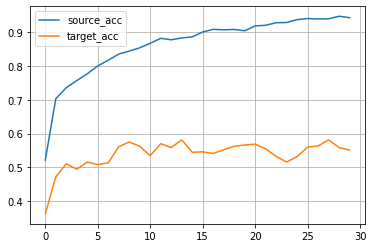

In [3]:
num_epochs = 30
history = main(num_epochs)
plot_graph(history['test_source_acc'], history['test_target_acc'],num_epochs,'source_acc','target_acc')